# LA IDEA DE ESTE NOTEBOOK ES IR MOSTRANDO LA MEJORA CONTINUA (o no) DEL SCORING MEDIANTE LAS DISTINTAS TECNICAS IMPLEMENTADAS

## Todo este proceso se hace con el dataset ya procesado y con las siguientes conclusiones:
- Las variables categóricas no son relevantes (por matriz de correlación y RFE)
- La variable "Time" es extremandamente influyente y, dependiendo el caso de aplicación, indeterminable. Por lo tanto se decide no utilizarla.
- Se debe aplicar StandarScaler() para obtener resultados coherentes en la mayoria de los modelos.
- Aplicar SMOTE, es decir, balancear las clases artificialmente (y de paso aumentar samples) tiene un gran efecto positivo en el scoring base (RF)
- El Baseline es un "RandomForestClassifier(random_state=69)" con un recall = 0.854+/-0.142 en sobre los datos de entrenamiento (Alto scoring y Alta varianza) y 0.667 sobre los datos de test (internos). Además obtenemos un ROC aoc = 0.875 y un PR aoc = 0.844.
---



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve 

In [3]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)

feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2,random_state=69)

scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)

feat_train, targ_train = SMOTE().fit_resample(feat_train, targ_train)

In [34]:
modelos = [
LogisticRegression(fit_intercept=False, max_iter=20000),
Pipeline([["poly",PolynomialFeatures(degree=2)],["regressor",LogisticRegression(fit_intercept=False, max_iter=20000, C=1.8047217668271664e-18)]]),
SVC(),
SVC(C=10.0, gamma=0.3831186849557287, kernel="rbf"),
DecisionTreeClassifier(),
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=500),
RandomForestClassifier(),
RandomForestClassifier(max_depth=8, min_samples_leaf=2, n_estimators=500),
AdaBoostClassifier(DecisionTreeClassifier()),
AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=500, learning_rate=0.1),
XGBClassifier(use_label_encoder=False, n_estimators=500, learning_rate=0.5, objective='binary:hinge', max_depth=7),
]
scores = []
scores_t = []
for model in modelos:
    model.fit(feat_train,targ_train)
    scores.append(cross_val_score(model, feat_train, targ_train,cv=10, scoring="recall"))
    scores_t.append(recall_score(targ_test,model.predict(scaler.transform(feat_test))))

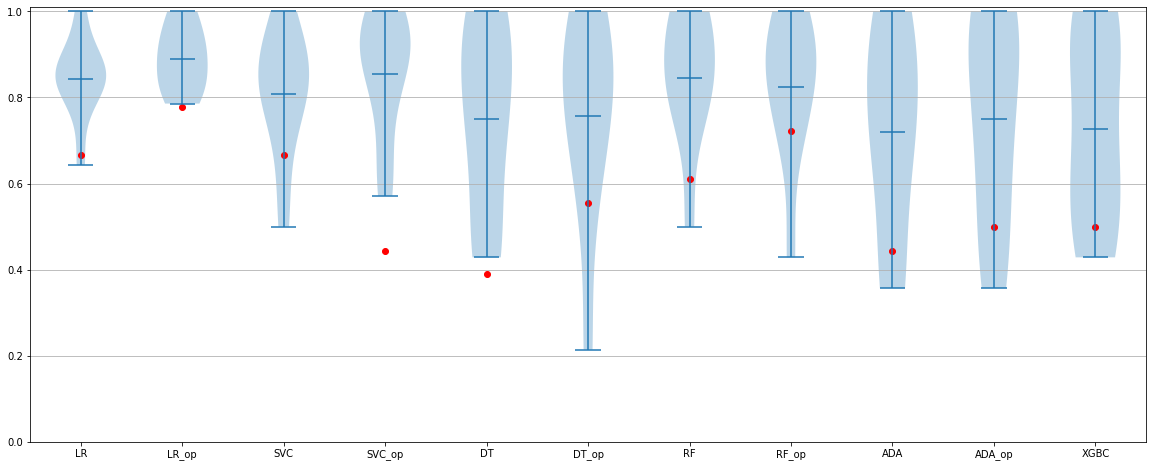

In [67]:
names = ["LR","LR_op","SVC","SVC_op","DT","DT_op","RF","RF_op","ADA","ADA_op","XGBC"]
plt.figure(figsize=(20,8))
plt.ylim([0, 1.01])
plt.grid(axis="y")
plt.violinplot(scores,showmeans=True,positions=[n for n in range(0,len(modelos))])
plt.scatter(names,scores_t,c="red")
plt.show()